In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle

cuda = torch.device('cuda')
frame_size = 10

In [13]:
ratings = pickle.load(open('../data/ratings_pos_11.pkl', 'rb'))
movies = torch.load('../data/enc_emb_pca.pt')
movies = dict([i, u] for i, u in enumerate(movies))
users =list(ratings.keys())
id_to_index = dict([(u, i) for i, u in enumerate(pd.read_csv('../data/ml-20m/movies.csv')['movieId'].values)])

In [14]:
class ML20mDataset(Dataset):
    def __init__(self):
        self.set_dataset(1)
    
    def set_dataset(self, u):
        self.user = u
        self.dataset = ratings[u]
        
    def __len__(self):
        return max(len(self.dataset) - frame_size, 0)
    
    def __getitem__(self, idx):
        ratings = self.dataset[idx:frame_size+idx+1]
        movie_chosen = ratings[:, 0][-1]
        films_watched = ratings[:, 0][:-1]
        
        films_lookup = torch.stack([movies[id_to_index[i]] for i in ratings[:, 0]])
        
        state = films_lookup[:-1].to(cuda).float()
        next_state = films_lookup[1:].to(cuda).float()
        
        rewards = torch.tensor(ratings[:, 1][:frame_size]).to(cuda).float()
        next_rewards = torch.tensor(ratings[:, 1][1:frame_size+1]).to(cuda).float()
        
        action = films_lookup[-1].to(cuda)
        
        reward = torch.tensor(ratings[:, 1][-1].tolist()).to(cuda).float()
        done = torch.tensor(idx == self.__len__() - 1).to(cuda).float()
        
        state = (state, rewards)
        next_state = (next_state, next_rewards)
        
        return state, action, reward, next_state, done

In [15]:
dset = ML20mDataset()

In [16]:
class StateRepresentation(nn.Module):
    def __init__(self, frame_size):
        super(StateRepresentation, self).__init__()
        self.frame_size = frame_size
        self.state_lin = nn.Sequential(
            # 33 = embed_size + rating
            nn.Linear(self.frame_size * (64 + 1), 64),
            nn.Tanh()
        ).to(cuda)
        
    def forward(self, info, rewards):
        rewards = torch.unsqueeze(rewards, 2)
        state = torch.cat([info, rewards],2)
        state = state.view(state.size(0), -1)
        state = self.state_lin(state)
        return state

In [17]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, frame_size, init_w=3e-3):
        super(Actor, self).__init__()
        
        self.frame_size = frame_size
        self.state_rep = StateRepresentation(frame_size)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, info, rewards):
        state = self.state_rep(info, rewards)
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return state, x
    
    def get_action(self, info, rewards):
        state, action = self.forward(info, rewards)
        return state, action

In [18]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        action = torch.squeeze(action)
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [19]:
import numpy as np
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = 64
        self.low          = -1
        self.high         = 1
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [20]:
def ddpg_update(batch, 
           gamma = 0.99,
           min_value=-5,
           max_value=5,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = batch
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    enc_state, current_action = policy_net(*state)
    
    policy_loss = value_net(enc_state, current_action)
    policy_loss = -policy_loss.mean()

    enc_next_state, next_action = target_policy_net(*next_state)
    target_value   = target_value_net(enc_next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(enc_state, action)
    
    value_loss = value_criterion(value, expected_value.detach())

    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
    return value_loss.item(), policy_loss.item()

In [21]:
ou_noise = OUNoise(64)

value_net  = Critic(64,64, 128).to(cuda)
policy_net = Actor(64, 64, 128, 10).to(cuda)

target_value_net  = Critic(64,64,128).to(cuda)
target_policy_net = Actor(64,64, 128, 10).to(cuda)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-4
policy_lr = 1e-5

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

In [ ]:
import visdom
v = visdom.Visdom()
assert v.check_connection()


value_plot = v.line([0], X=[0], opts=dict(title="value_loss", ))
policy_plot = v.line([0], X=[0], opts=dict(title="policy_loss", ))

v_loss, p_loss = [], []
gstep = 0

b_size = 100
n_epochs = 10

def form_batch(batch_list):
    b = []
    for i in batch_list:
        if isinstance(i[0], tuple):
            b.append((
                torch.stack([t[0] for t in i]).to(cuda),
                torch.stack([t[1] for t in i]).to(cuda)
            ))
        else:
            b.append(torch.stack(i).to(cuda))
    return b

current_batch = [[] for i in range(5)]

epoch_bar = tqdm(total=n_epochs)
batch_bar = tqdm(total=len(users))

for batch in range(10):
    epoch_bar.refresh()
    #target_policy_net.load_state_dict(torch.load("../models/target_policy.pt"))
    #target_value_net.load_state_dict(torch.load("../models/target_value.pt"))
    
    for u in users:
        dset.set_dataset(u)
        batch_bar.update(1)
        for b in range(len(dset)):
            if np.random.rand() > 0.2: #intake percents
                continue
            minibatch = dset[b]
            [current_batch[i].append(minibatch[i]) for i in range(5)]
            if len(current_batch[0]) >= b_size:
                current_batch = form_batch(current_batch)
                value_loss, policy_loss = ddpg_update(current_batch)
                v_loss.append(value_loss)
                p_loss.append(policy_loss)
                v.line(np.array([value_loss]), X=[gstep], win=value_plot, update='append')
                v.line(np.array([policy_loss]), X=[gstep], win=policy_plot, update='append')
                gstep += 1
                current_batch = [[] for i in range(5)]
                
    epoch_bar.update(1)
    torch.save(target_policy_net.state_dict(), "../models/target_policy.pt")
    torch.save(target_value_net.state_dict(), "../models/target_value.pt")

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Text(0.5,1,'Policy loss')

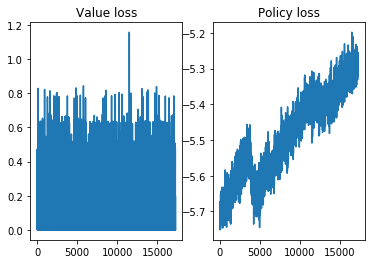

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(v_loss)), v_loss)
ax1.set_title('Value loss')
ax2.plot(range(len(p_loss)), p_loss)
ax2.set_title('Policy loss')

In [3]:
'''
to_delete = []
for i in ratings.keys():
    ratings[i] = ratings[i][ratings[i][:,1] >= 0]
    if len(ratings[i]) < 11:
        to_delete.append(i)
        
for i in to_delete:
    del ratings[i]
    
pickle.dump(ratings, open('../data/ratings_pos_11.pkl', 'wb'))
'''